In [31]:
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.colors as colors
import matplotlib.dates as mdates
from matplotlib.patches import Ellipse
from matplotlib.cm import ScalarMappable
import matplotlib.pyplot as plt
import croissant as cro
import healpy as hp
from astropy.time import Time
from hera_filters import dspec
from scipy.special import sph_harm_y_all


%matplotlib widget

In [2]:
d = np.load("sim_v003.npz")
for k, v in d.items():
    print(k, v.shape)

freqs = d["freqs"] / 1e6  # mhz
az, alt = d["azalts"].T
data = d["data"]
times = d["times"]  # jd
tx_crds = d["tx_crds_topo"][:, 0]
tx_flux = d["tx_flux"][0]

# az and alt both go 0-2pi which is unneccsary
data = data[:, alt <= np.pi]
az = az[alt <= np.pi]
alt = alt[alt <= np.pi]

# remove the last time which would mess up time averages (double counting since first == last)
data = data[:-1]
times = times[:-1]

# mask transmitter channels
tx_freq = freqs[::16]
tx_mask = np.zeros(data.shape, dtype=bool)
tx_mask[:, :, ::16] = True
print(tx_freq)
data = np.ma.array(data, mask=tx_mask)
tx_mask_1d = tx_mask[0, 0]

freqs (1024,)
data (144, 1296, 1024)
azalts (1296, 2)
times (144,)
tx_crds_topo (3, 1)
tx_flux (1, 1024)
[ 50.          53.12805474  56.25610948  59.38416422  62.51221896
  65.6402737   68.76832845  71.89638319  75.02443793  78.15249267
  81.28054741  84.40860215  87.53665689  90.66471163  93.79276637
  96.92082111 100.04887586 103.1769306  106.30498534 109.43304008
 112.56109482 115.68914956 118.8172043  121.94525904 125.07331378
 128.20136852 131.32942326 134.45747801 137.58553275 140.71358749
 143.84164223 146.96969697 150.09775171 153.22580645 156.35386119
 159.48191593 162.60997067 165.73802542 168.86608016 171.9941349
 175.12218964 178.25024438 181.37829912 184.50635386 187.6344086
 190.76246334 193.89051808 197.01857283 200.14662757 203.27468231
 206.40273705 209.53079179 212.65884653 215.78690127 218.91495601
 222.04301075 225.17106549 228.29912023 231.42717498 234.55522972
 237.68328446 240.8113392  243.93939394 247.06744868]


In [3]:
tstart, tstop = Time([times[0], times[-1]], format="jd").to_datetime()
print(tstart, tstop)
extent = [freqs[0], freqs[-1], tstop, tstart]

def waterfall(data, log=False, vmin=None, vmax=None, aspect="auto", extent=extent, interpolation="none", cmap="plasma", title=None):
    if log:
        norm = colors.LogNorm(vmin=vmin, vmax=vmax)
    else:
        norm = colors.Normalize(vmin=vmin, vmax=vmax)
    plt.figure()
    plt.imshow(data, aspect=aspect, extent=extent, interpolation=interpolation, cmap=cmap, norm=norm)
    plt.gca().yaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    plt.colorbar()
    if title:
        plt.title(title)
    plt.show()

2024-10-17 18:00:00 2024-10-18 17:49:55.804203


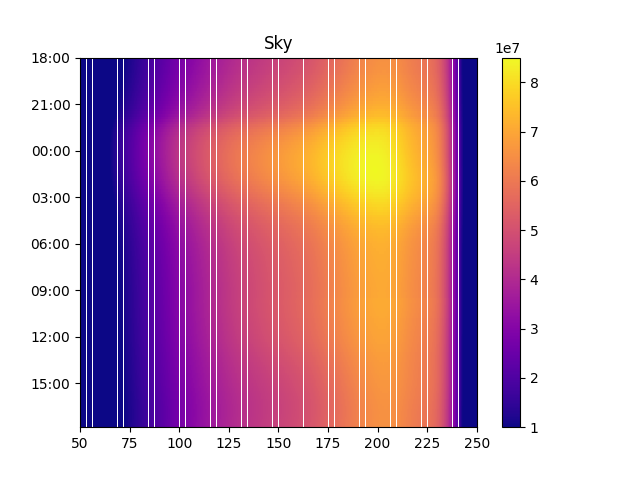

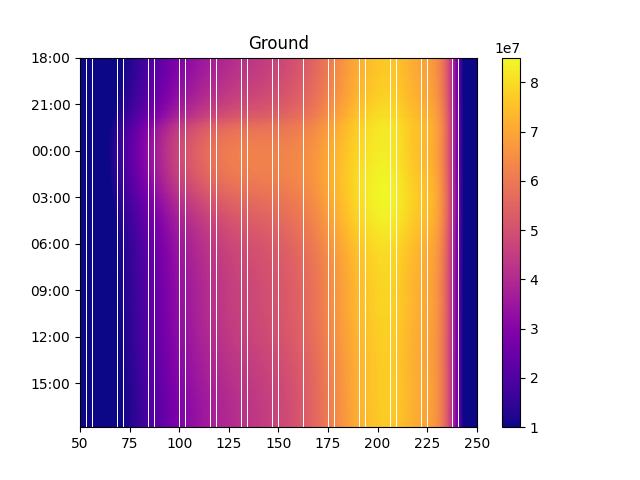

In [4]:
waterfall(data[:, 0], log=False, vmin=1e7, vmax=8.5e7, title="Sky")
waterfall(data[:, -36], log=False, vmin=1e7, vmax=8.5e7, title="Ground")

### Beam Mapping

Assume that ground, sky, bandpasses are smooth enough that we can subtract DPSS model and read of the transmitter values as a direct probe for the beam gain.

Note here that we think of the beam as the product of the beam directivity and the gain/bandpass/beam efficiency. The beam in this interpretation introduces frequency dependent multiplicative gain which distorts shapes. Need to get that calibrated out of course, as it changes the shape of monopole signals.

We use the time averaged spectra first as they remove non-monopole components of the sky. (Actually, m=0 components stays, but unclear how much it matters given the horizon.)

In [5]:
flat_data = data.reshape(-1, freqs.size)
wgts = np.logical_not(flat_data.mask).astype(int)
fhw = (freqs[1]-freqs[0])/2  # each flag is 1 channel so we need to cover at least that
eval_cutoff = 1e-15
model, res, info = dspec._fit_basis_2d(freqs, flat_data.data, wgts, [0], [fhw], {"eigenval_cutoff": [eval_cutoff]}, method="leastsq", basis="dpss", filter_dims=1, skip_wgt=0)
model.shape = data.shape
res.shape = data.shape

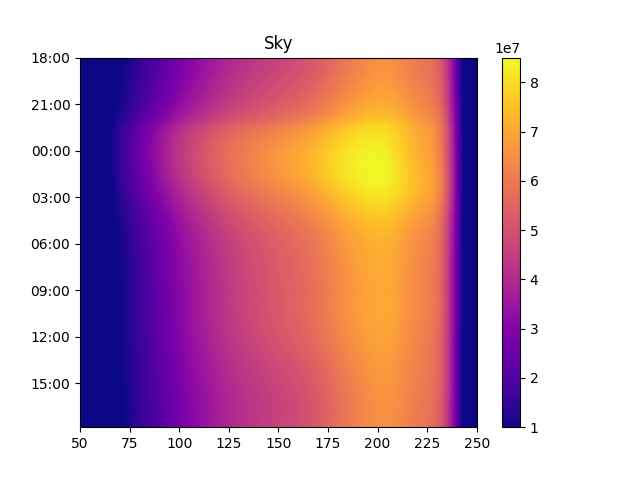

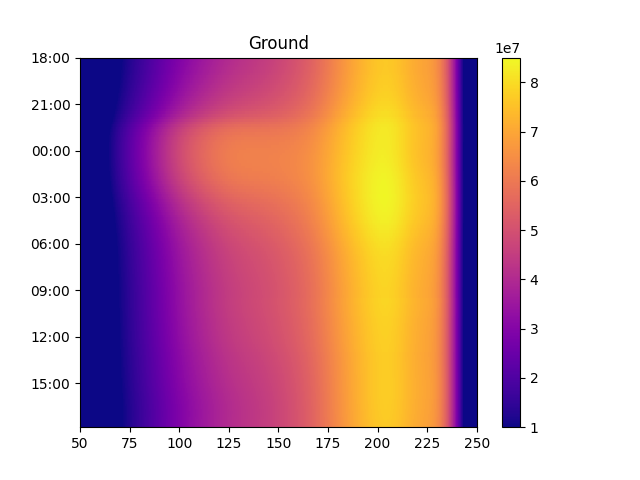

In [6]:
waterfall(model[:, 0], log=False, vmin=1e7, vmax=8.5e7, title="Sky")
waterfall(model[:, -36], log=False, vmin=1e7, vmax=8.5e7, title="Ground")

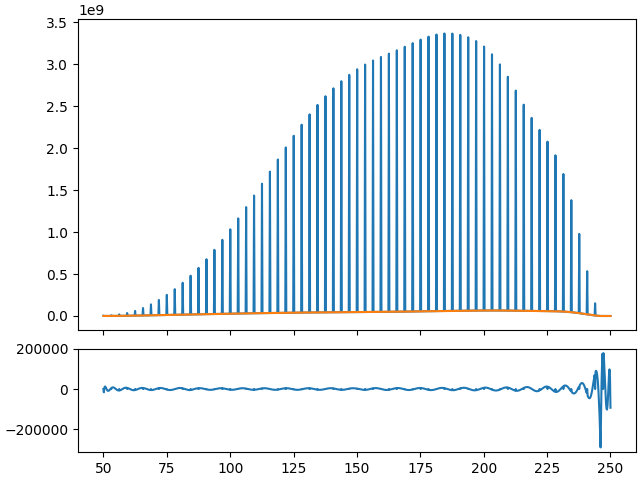

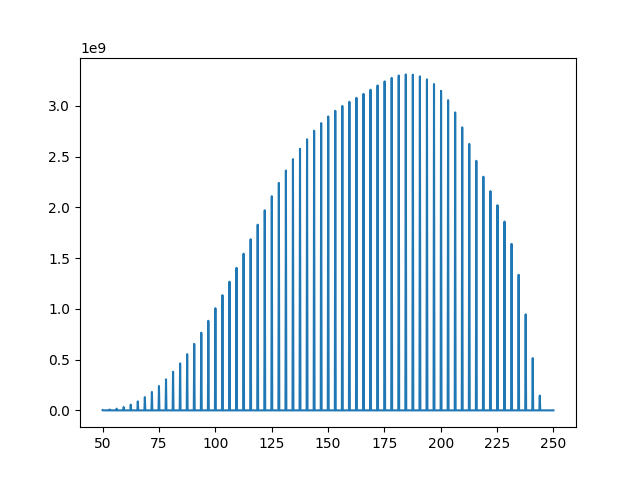

In [7]:
fig, axs = plt.subplots(nrows=2, constrained_layout=True, sharex=True, gridspec_kw={'height_ratios': [3, 1]})
axs[0].plot(freqs, data.data[0, 0])
axs[0].plot(freqs, model[0, 0])
axs[1].plot(freqs, res[0, 0])
plt.show()

tx_data = (data.data - model).mean(axis=0)  # shape angle, freq
plt.figure()
plt.plot(freqs, tx_data[0])
plt.show()

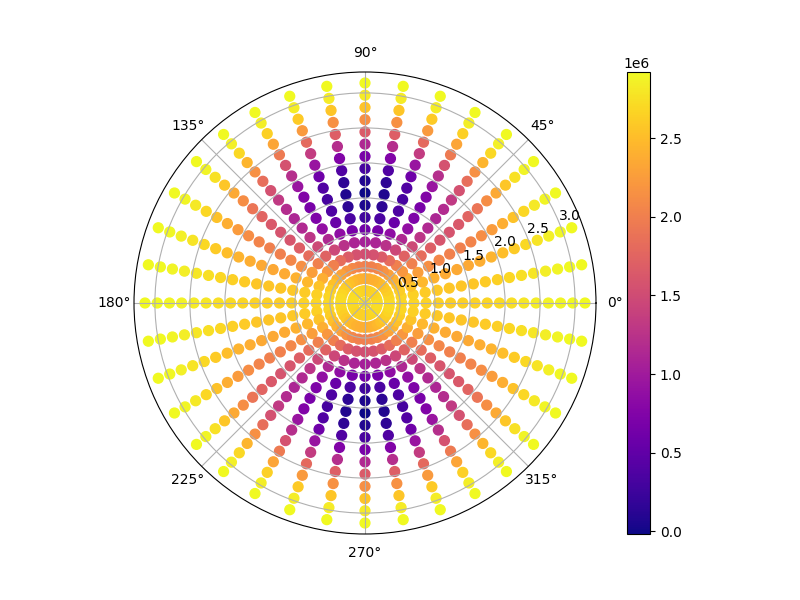

In [8]:
# this is the beam in normal topocentric coordinates
fig, ax = plt.subplots(subplot_kw={"projection": "polar"}, figsize=(8, 6))
sc = ax.scatter(az, np.pi-alt, c=tx_data[..., 0], cmap="plasma", s=50)
plt.colorbar(sc, ax=ax, label="")
plt.show()

(190, 684) (190,)
(684, 190) (684, 64) (190,)


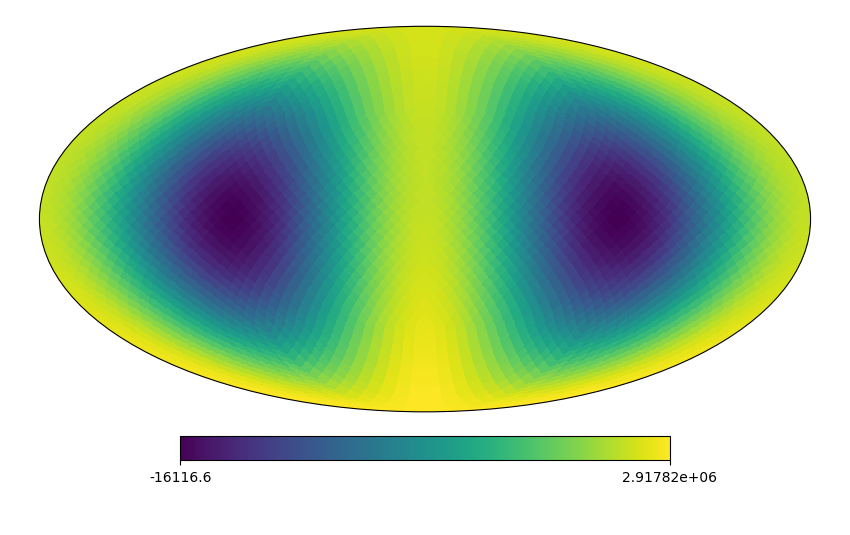

In [217]:
# with 19 thetas and 36 phis, we can fit up to lmax of 18
lmax = 18
theta = np.pi - alt
phi = az.copy()
ylm = sph_harm_y_all(lmax, lmax, theta, phi)  # normalization is same as Healpy
# switch to healpy ordering
ylm_hp = np.zeros((hp.Alm.getsize(lmax), az.size), dtype=complex)
Lmat = np.zeros(hp.Alm.getsize(lmax), dtype=float)
for i in range(len(ylm_hp)):
    ell, emm = hp.Alm.getlm(lmax, i=i) 
    ylm_hp[i] = ylm[ell, emm]
    Lmat[i] = ell * (ell + 1)
print(ylm_hp.shape, Lmat.shape)

Amat = ylm_hp.T
bvec = tx_data[:, ::16]
print(Amat.shape, bvec.shape, Lmat.shape)
AtA = Amat.conj().T @ Amat
Atb = Amat.conj().T @ bvec

def fit(lam=1e-3, return_res=False):
    reg_mat = lam * np.diag(Lmat)
    xvec = np.linalg.solve(AtA + reg_mat, Atb)
    beam_alm = xvec.T.copy()
    if not return_res:
        return beam_alm
    res = bvec - Amat @ xvec
    return beam_alm, res

beam_alm = fit(lam=1e-9)
beam_map = hp.alm2map(beam_alm[0], 16)
hp.projview(beam_map)
plt.show()

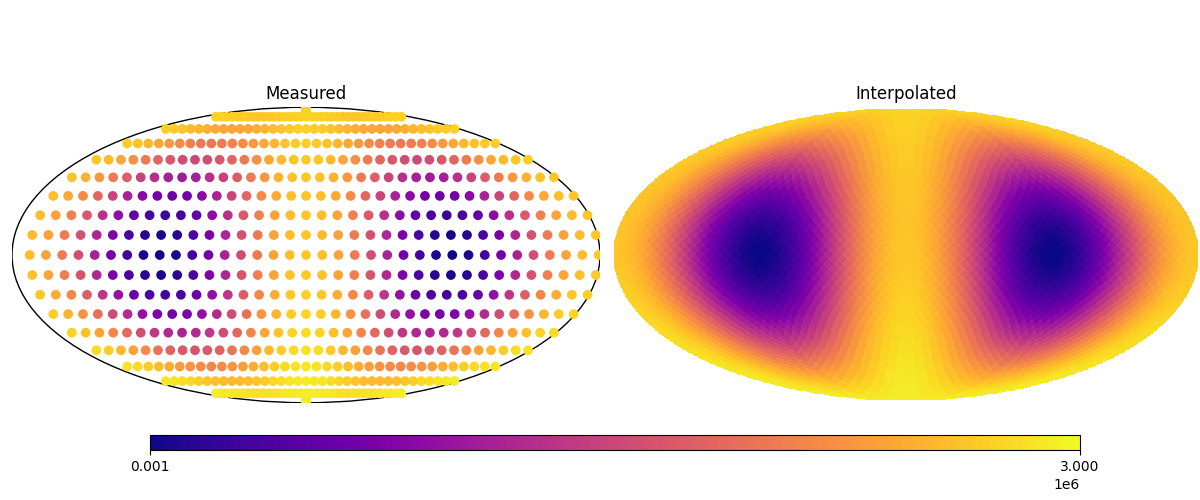

In [218]:
vmin = 1e3
vmax = 3e6
norm = colors.Normalize(vmin=vmin, vmax=vmax)
cmap = "plasma"
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)

fig = plt.figure(figsize=(12, 5))
hp.mollview(np.zeros_like(beam_map), fig=fig, cmap="gray_r", title="Measured", cbar=False, min=0, max=1, sub=(1, 2, 1))
ax1 = plt.gca()
xlim = ax1.get_xlim()
ylim = ax1.get_ylim()
width = xlim[1] - xlim[0]
height = ylim[1] - ylim[0]
center = (np.mean(xlim), np.mean(ylim))
outline = Ellipse(xy=center, width=width, height=height, edgecolor='black', facecolor='none')
ax1.add_patch(outline)
hp.projscatter(np.pi-alt, az, c=tx_data[:, 0], cmap=cmap, norm=norm)
hp.mollview(beam_map, fig=fig, cmap=cmap, title="Interpolated", min=vmin, max=vmax, cbar=False, sub=(1, 2, 2))
ax2 = plt.gca()
plt.subplots_adjust(bottom=0.2, top=0.95)
cbar_ax = fig.add_axes([0.125, 0.1, 0.775, 0.03])
cbar = fig.colorbar(sm, cax=cbar_ax, orientation="horizontal", ticks=[vmin, vmax])#shrink=0.75, aspect=25, fraction=0.1, pad=0.05, ticks=[vmin, vmax])
plt.show()

In [219]:
beam_alm.shape

(64, 190)

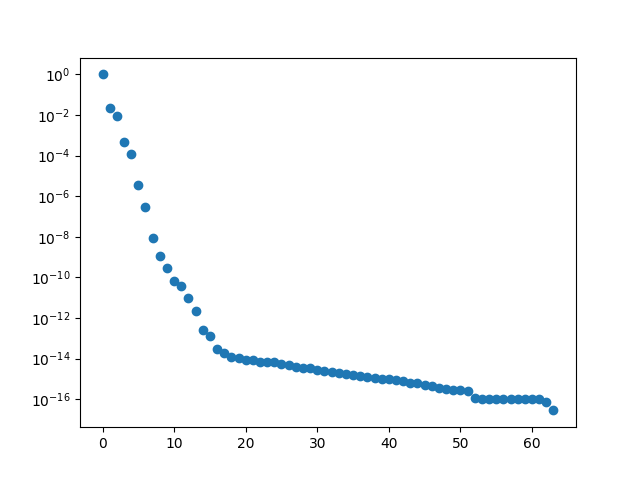

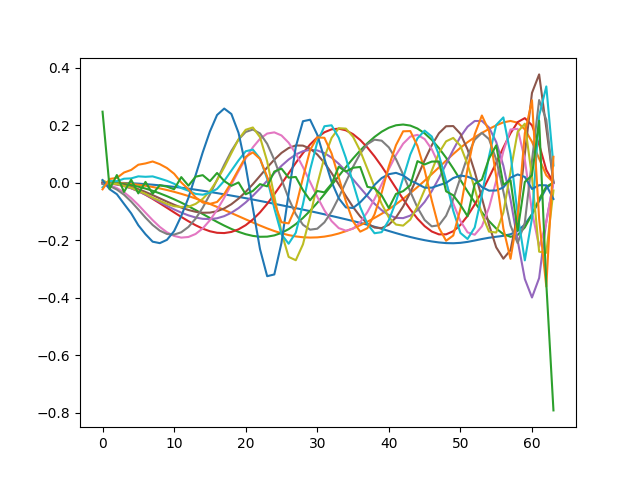

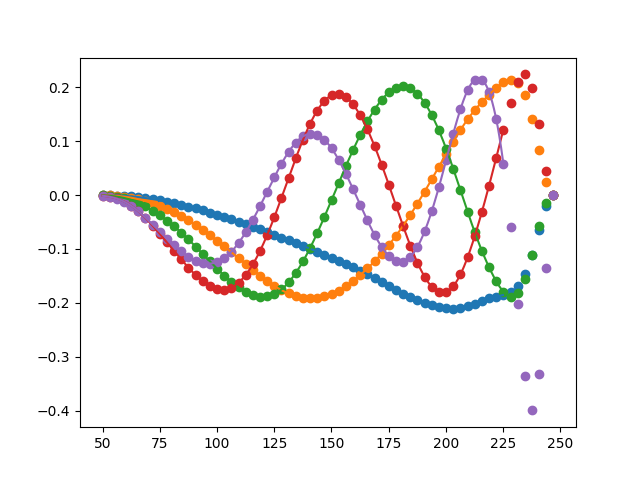

In [221]:
fmax = 225
fmask = freqs < fmax
fcut = freqs[fmask]
datacut = data[..., fmask]
tx_mask_1dcut = tx_mask_1d[fmask]

cov = beam_alm @ beam_alm.T
u, s, vt = np.linalg.svd(cov)
plt.figure()
plt.plot(s/s[0], marker="o", ls="none")
plt.yscale("log")
plt.show()

Nvecs = 13
plt.figure()
plt.plot(vt[:Nvecs].T)
plt.show()

plt.figure()
pca_interp = np.empty((len(vt), fcut.size))
for i, evec in enumerate(vt):
#    pca_interp[i] = np.polyval(np.polyfit(tx_freq, evec, i+2), freqs)
    pca_interp[i] = interp1d(tx_freq, evec, kind="cubic")(fcut)
    if i < 5:
        plt.scatter(tx_freq, evec)
        plt.plot(fcut, pca_interp[i])
plt.show()

In [10]:
# pca_interp is A.t, 
# do lls fit on tx freq subset of pca_interp (vt), LLS = inv(At @ A) @ At @ beam_mdl
Amat = vt.T
pca_params = np.linalg.inv(Amat.T @ Amat) @ Amat.T @ beam_mdl
print(pca_params.shape)
# then A @ fit -> interpolation
full_A = pca_interp.T
beam_full = full_A @ pca_params
print(beam_full.shape)

(13, 3072)
(175, 3072)


In [39]:
# normalize beam so it doesn't change total power sans ground loss effect
bandpass = beam_full.sum(axis=1) * hp_dA
beam = beam_full / bandpass[:, None]

#plt.figure()
#plt.plot(fcut, bandpass)
#plt.yscale("log")
#plt.show()

#waterfall(datacut[:, 0] / bandpass, log=False)#, vmin=1e7, vmax=8.5e7)
#waterfall(datacut[:, -18] / bandpass, log=False)

In [12]:
plt.close("all")

Trying to separate the sky and the ground. Since we're doing the time average, we should be mostly monpole signal. That is, denoting the average beam above (below) the horizon by $A^+$ ($A^-$), we get

$$T_{\rm up} = T_{\rm gsm, mono} A^+ + T_{\rm gnd} A^- $$
$$T_{\rm down} = T_{\rm gsm, mono} A^- + T_{\rm gnd} A^+ $$

This is not exact because there are other parts of the sky that do not move with time besides the monopole, but it's probably pretty good. Actually, averaging over azimuthal angle would improve this further so we are also doing that.

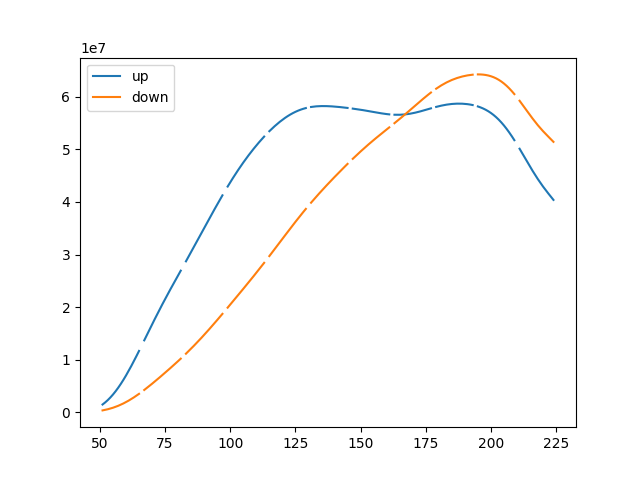

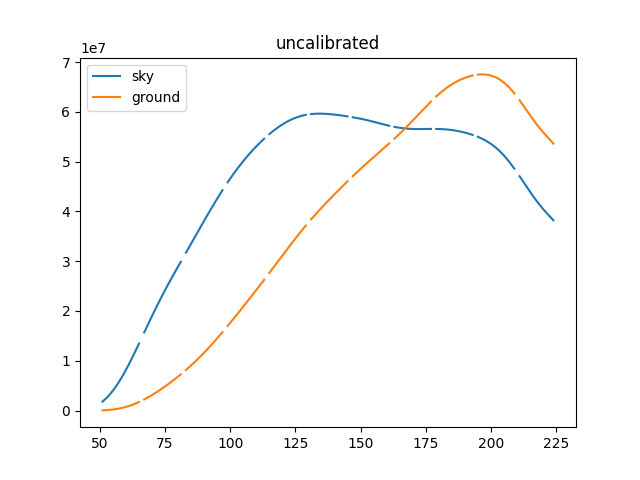

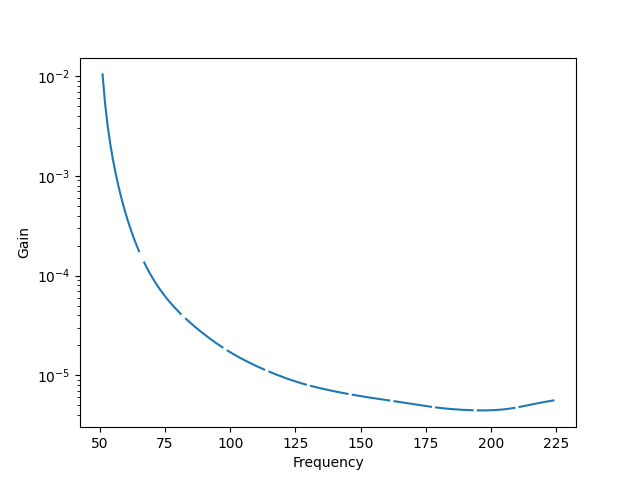

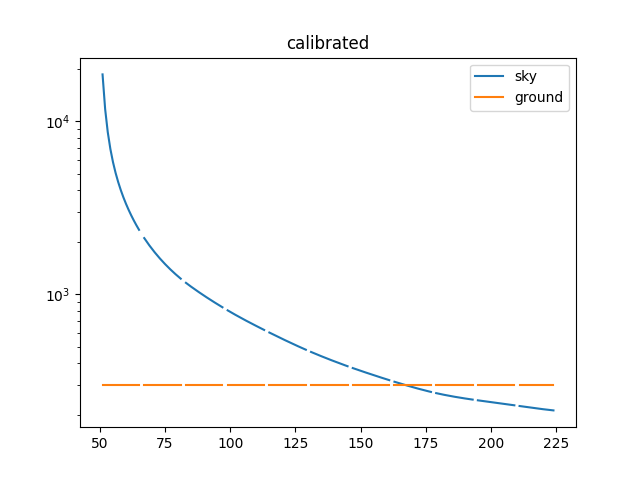

In [16]:
T_up = datacut.data[:, :18].mean(axis=(0, 1))# / bandpass
T_down = datacut.data[:, -18:].mean(axis=(0, 1))# / bandpass

T_up = np.ma.array(T_up, mask=tx_mask_1dcut)
T_down = np.ma.array(T_down, mask=T_up.mask)

# there's clearly sky present here
plt.figure()
plt.plot(fcut, T_up, label="up")
plt.plot(fcut, T_down, label="down")
plt.legend()
plt.show()

# since we're time and azimuth averaged, the sky is ~ monopole
beam_th, beam_ph = hp.pix2ang(nside, np.arange(npix), lonlat=False)
# HORIZON_THETA = np.pi /2 
#HORIZON_THETA = np.pi/3  # 60 degrees 
HORIZON_THETA = np.deg2rad(105)
Aplus = beam_full[:, beam_th <= HORIZON_THETA].sum(axis=1) / beam_full.sum(axis=1)
Aminus = beam_full[:, beam_th > HORIZON_THETA].sum(axis=1) / beam_full.sum(axis=1)
# we can invert the equation above in our heads of course
inv_mixing = np.array([[Aplus, -Aminus], [-Aminus, Aplus]]) / (Aplus**2 - Aminus**2)
T_comp = np.einsum("ijf, jf -> if", inv_mixing, np.array([T_up.data, T_down.data]))
sky_mono_spec = np.ma.array(T_comp[0], mask=T_up.mask)
gnd_spec = np.ma.array(T_comp[1], mask=T_up.mask)

plt.figure()
plt.plot(fcut, sky_mono_spec, label="sky")
plt.plot(fcut, gnd_spec, label="ground")
plt.title("uncalibrated")
plt.legend()
plt.show()

T_GND = 300 # just an assumption but at most we're off by a freq independent scale
gain = T_GND / gnd_spec

plt.figure()
plt.plot(fcut, gain)
plt.ylabel("Gain")
plt.xlabel("Frequency")
plt.yscale("log")
plt.show()

plt.figure()
plt.plot(fcut, sky_mono_spec * gain, label="sky")
plt.plot(fcut, gnd_spec * gain, label="ground")
plt.title("calibrated")
plt.legend()
plt.yscale("log")
plt.show()

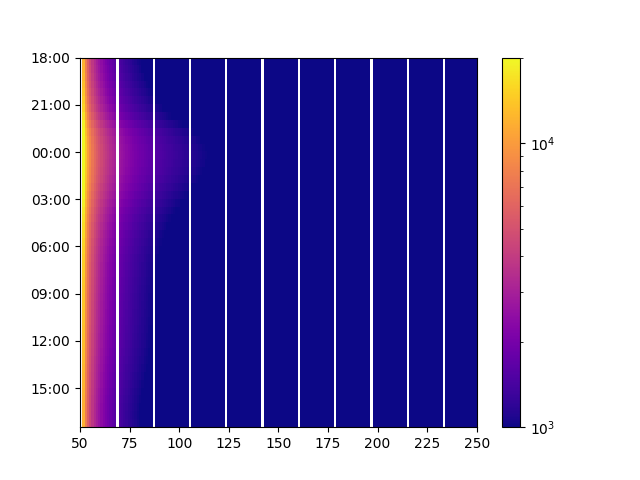

In [17]:
cal_data = datacut * gain[None, None, :]
waterfall(cal_data[:, 0], log=True, vmin=1e3, vmax=2e4)

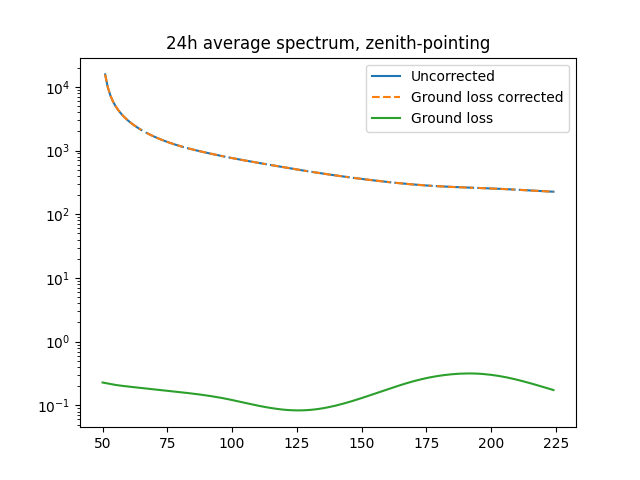

In [18]:
gnd_signal = Aminus * T_GND * hp_dA
sky_data = cal_data[:, 0] - gnd_signal

plt.figure()
plt.plot(fcut, cal_data[:, 0].mean(axis=0), label="Uncorrected")
plt.plot(fcut, sky_data.mean(axis=0), ls="--", label="Ground loss corrected")
plt.plot(fcut, gnd_signal, label="Ground loss")
plt.legend()
plt.title("24h average spectrum, zenith-pointing")
plt.yscale("log")
plt.show()

When we're pointing down, the signal at transmitter frequencies is the sum of:
- zenith beam X transmitter power
- above horizon beam X ground
- below horizon beam X sky

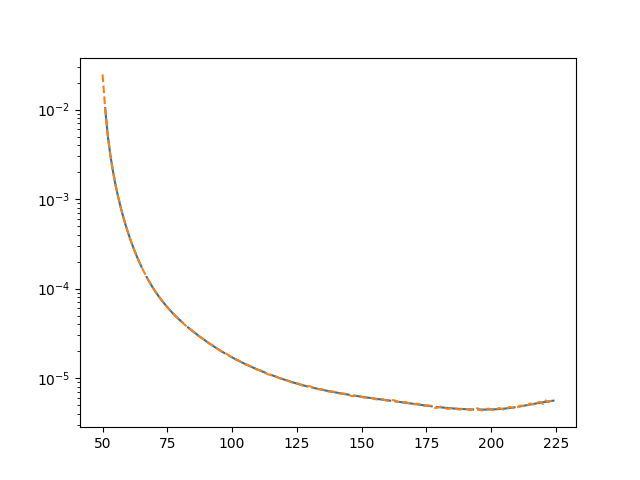

In [28]:
# first we need to interpolate the gain model
weights = np.logical_not(gain.mask).astype(int)
gain_mdl, res, info = dspec.fourier_filter(fcut/1e3, gain.data, weights, [0], [200], "dpss_solve", eigenval_cutoff=[1e-12])

plt.figure()
plt.plot(fcut, gain)
plt.plot(fcut, gain_mdl, ls="--")
plt.yscale("log")
plt.show()

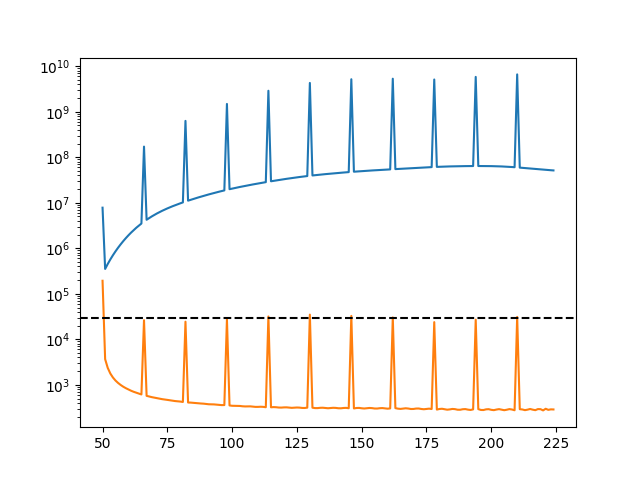

In [38]:
plt.figure()
plt.plot(fcut, T_down.data)
plt.plot(fcut, T_down.data * gain_mdl)
plt.axhline(np.mean((T_down.data * gain_mdl)[::16][1:]), ls="--", c="k")
plt.yscale("log")
plt.show()

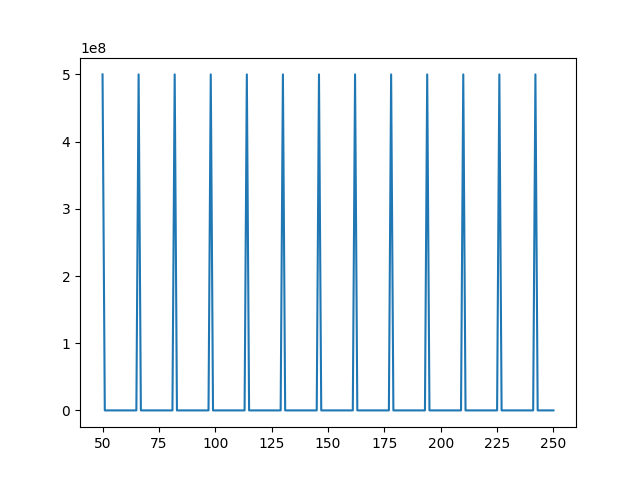

In [8]:
plt.figure()
plt.plot(freqs, tx_flux)
plt.show()

0.0 180.0


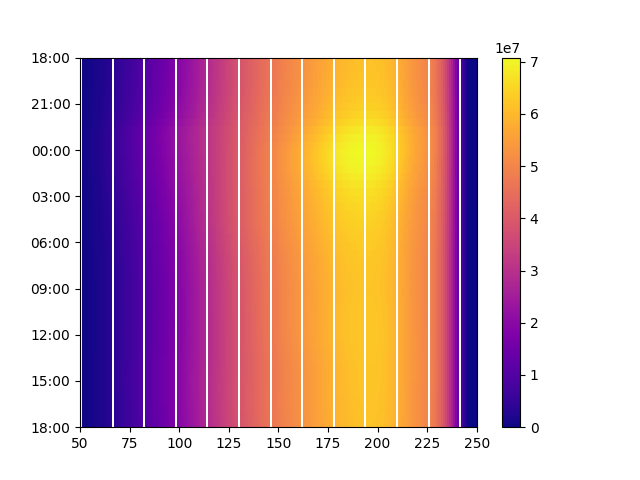

In [9]:
# ground temp as absolute calibration
print(np.rad2deg(az[-18]), np.rad2deg(alt[-18]))
waterfall(data[:, -18, :], log=False)

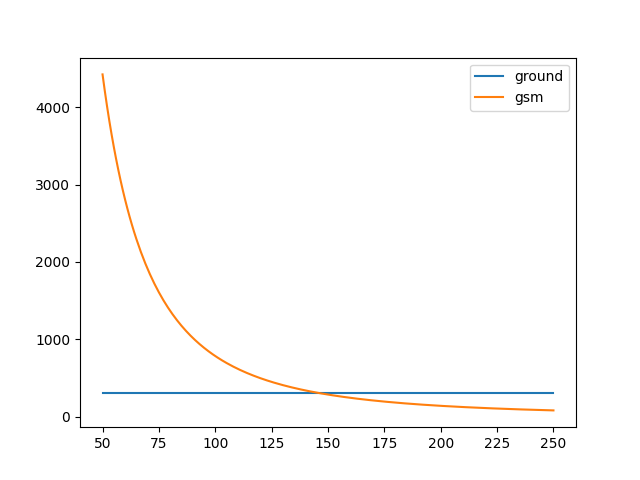

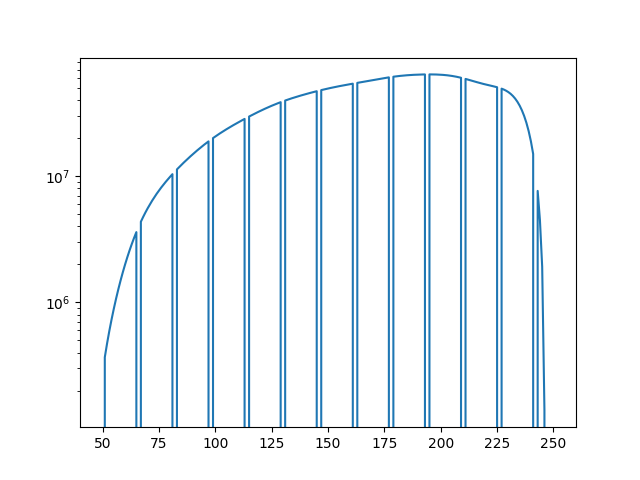

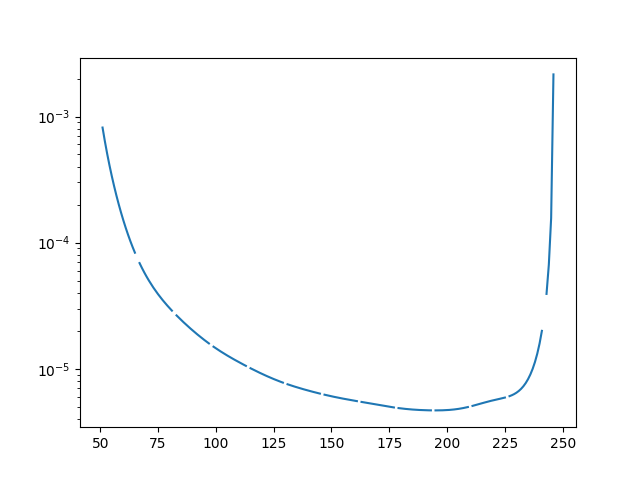

In [14]:
T_gnd = 300  # guess
T_gsm_mono = 180 * (freqs/180)**(-2.5)
plt.figure()
plt.plot(freqs, np.full_like(freqs, T_gnd), label="ground")
plt.plot(freqs, T_gsm_mono, label="gsm")
plt.legend()
plt.show()
# sky contribution is mostly monopole if we avg, so since we're looking down we should be mostly OK
t_avg = data[:, -18].mean(axis=0)
plt.figure()
plt.plot(freqs, t_avg.data)
plt.yscale("log")
plt.show()

# fractional contribution of sky is ~ 1 %, NOTE: THIS IS FREQ DEPENDENT
#fsky = 1e-2
fsky = 0  # turn off sky
t_cal = (1-fsky) * T_gnd + fsky * T_gsm_mono
gain = t_cal / t_avg
plt.figure()
plt.plot(freqs, gain)
plt.yscale("log")
plt.show()

In [15]:
# use dpss to fit gain from 50 to 225
fmin = 50
fmax = 225
fmask = (freqs >= fmin) & (freqs <= fmax)

fcut = freqs[fmask]
gain = gain[fmask]
weights = np.ones(fcut.size)
weights[::16] = 0  # tx freqs

mdl, res, info = hera_filters.dspec.fourier_filter(fcut/1e3, gain.data, weights, [0], [200], "dpss_solve", eigenval_cutoff=[1e-12])

print(info)

{'status': {'axis_0': {}, 'axis_1': {0: 'success'}}, 'filter_params': {'axis_0': {}, 'axis_1': {'method': 'solve', 'basis': 'dpss', 'filter_centers': [0], 'filter_half_widths': [200], 'suppression_factors': [1e-09], 'basis_options': {'eigenval_cutoff': [1e-12]}, 'mode': 'dpss_solve'}}}


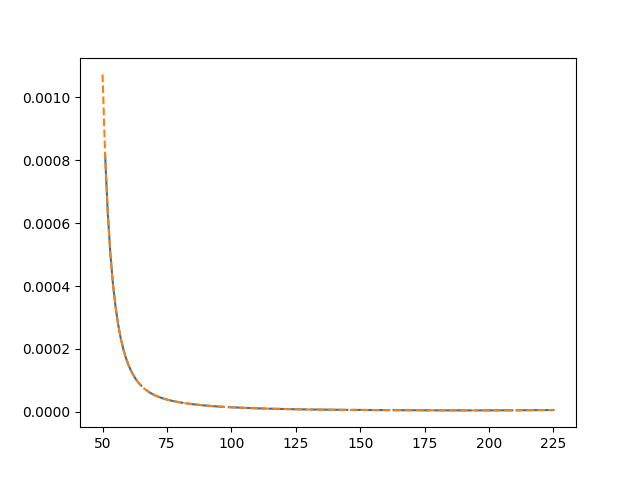

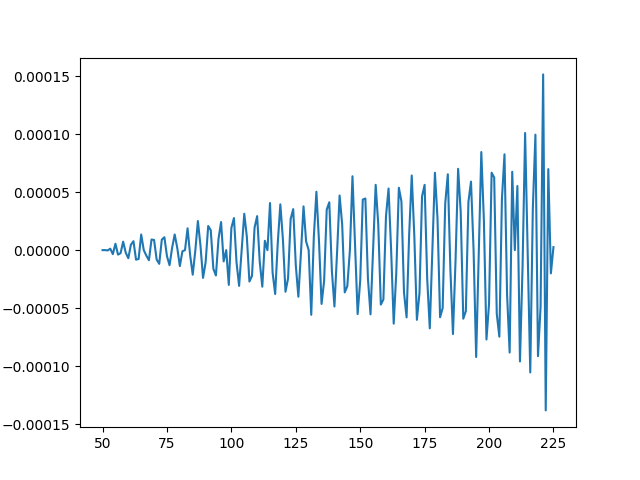

In [16]:
plt.figure()
plt.plot(fcut, gain)
plt.plot(fcut, mdl, ls="--")
plt.show()

plt.figure()
plt.plot(fcut, res/gain.data)
plt.show()

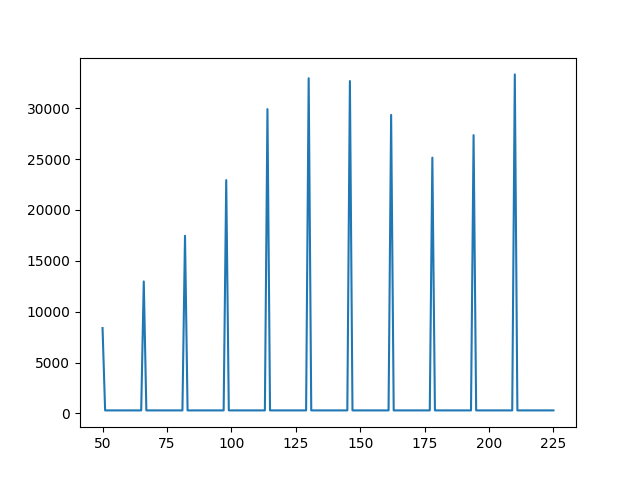

In [17]:
cal_data = data.data[:, :, fmask] * mdl

plt.figure()
plt.plot(fcut, cal_data[:, -18].mean(axis=0))
plt.show()